# NFL 4th Down Analysis 

## Initial Analysis
Here is a bunch of Analysis about 4th down.  First we start by loading the data and converting all play types into numerical codes.

In [64]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy import stats
from statsmodels.formula.api import ols
warnings.simplefilter(action = "ignore")

all_plays = pd.read_csv('../data/nflplaybyplay2015.csv')
play_codes = {'Punt': 'Punt', 'Field Goal': 'Field Goal', 'Pass': 'Play Attempt (Pass/Run/Sack)', 'No Play': 'Other', 'Run': 'Play Attempt (Pass/Run/Sack)', 'Sack': 'Play Attempt (Pass/Run/Sack)', 'QB Kneel': 'Other', 'Timeout': 'Other'}
all_plays['Play'] = all_plays['PlayType'].map(play_codes)

short_flag = all_plays['ydstogo'] < 5
med_flag = (all_plays['ydstogo'] >= 5) & (all_plays['ydstogo'] <= 10)
long_flag = all_plays['ydstogo'] > 10

all_plays.loc[short_flag, 'dist_cat'] = 'Short'
all_plays.loc[med_flag, 'dist_cat'] = 'Medium'
all_plays.loc[long_flag, 'dist_cat'] = 'Long'


Create a dataframe of just the 4th Down Plays

In [65]:
other_plays = all_plays[all_plays['down'] != 4]
fourth_plays = all_plays[all_plays['down'] == 4]
fourth_plays = fourth_plays.drop(['Unnamed: 0', 'PlayAttempted', 'Season'], 1)
converted_flag = fourth_plays['ydstogo'] > fourth_plays['Yards.Gained']
fourth_plays['converted'] = 1
fourth_plays.loc[converted_flag, 'converted'] = 0



Create some other dataframes that divide up the fourth down plays by attempts, punts, field goals and other.  Do the same for first quarter, second quarter, third quarter and fourth.

In [66]:
attempts = fourth_plays[fourth_plays['Play'] == 'Play Attempt (Pass/Run/Sack)']
punts = fourth_plays[fourth_plays['Play'] == 'Punt']
field_goals = fourth_plays[fourth_plays['Play'] == 'Field Goal']
other_plays = fourth_plays[fourth_plays['Play'] == 'Other']

first_qtr = fourth_plays[fourth_plays['qtr'] == 1]
second_qtr = fourth_plays[fourth_plays['qtr'] == 2]
third_qtr = fourth_plays[fourth_plays['qtr'] == 3]
fourth_qtr = fourth_plays[fourth_plays['qtr'] == 4]

## Distribution of Play Type
### How far away are we?

In [67]:
att = attempts['yrdline100']
punt = punts['yrdline100']
fg = field_goals['yrdline100']
other = other_plays['yrdline100']
rows = ['4th Down Attempt', 'Punt', 'FG', 'Other']
    
distance_avg = [round(np.mean(att), 2), round(np.mean(punt), 2), round(np.mean(fg), 2), round(np.mean(other), 2)]
distance_mode = [stats.mode(att).mode, stats.mode(punt).mode, stats.mode(fg).mode, stats.mode(other).mode]
distance_sd = [round(np.std(att), 2), round(np.std(punt), 2), round(np.std(fg), 2), round(np.std(other), 2)]    
tbl = Table([rows, distance_avg, distance_mode, distance_sd], names=('Type', 'Average Dist to Goal', 'Mode', 'SD'))
print(tbl)

      Type       Average Dist to Goal Mode [1]   SD 
---------------- -------------------- -------- -----
4th Down Attempt                38.43     38.0 22.32
            Punt                66.41     75.0 14.88
              FG                19.93     30.0 10.21
           Other                49.05     73.0 24.79


We see that 4th down attempts occur around the 38 yard line, a mark that is inbetwen the average punt and fg line.  This is not particularly a surpirse.  However, we note that 4th down attempts have a much larger spread than punts and FG.  This is most likely due to the variety of when 4th downs need to be completed (ie at the end of games a team that is down may be forced to attempt a 4th and long). 

## Distribution of Play Type by Distance to Goal

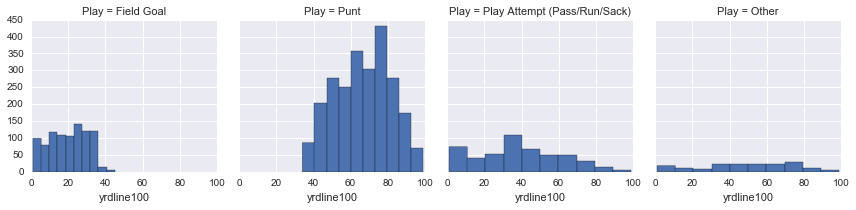

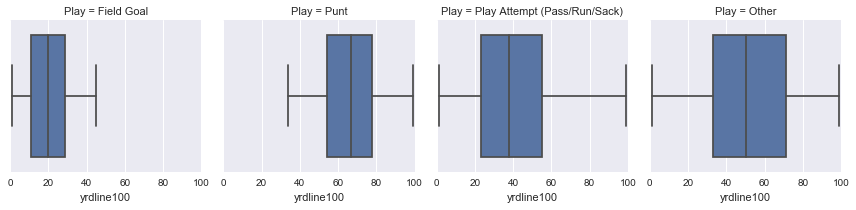

In [68]:
g1 = sns.FacetGrid(fourth_plays, col='Play')
g1.map(plt.hist, 'yrdline100')
g2 = sns.FacetGrid(fourth_plays, col='Play')
g2.map(sns.boxplot, 'yrdline100')
sns.plt.show()

## Distribution of Play Type by Time Left

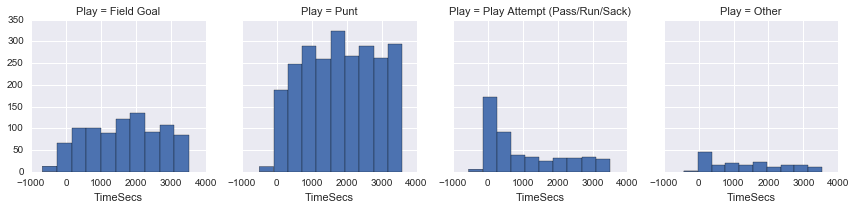

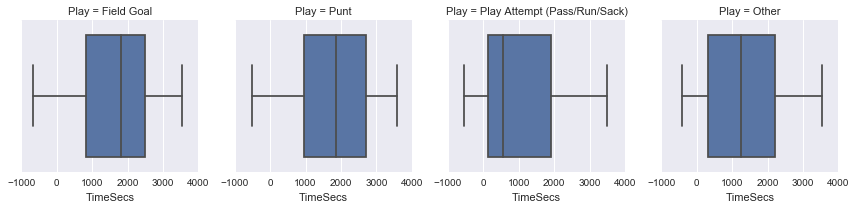

In [69]:
g1 = sns.FacetGrid(fourth_plays, col='Play')
g1.map(plt.hist, 'TimeSecs')

g1 = sns.FacetGrid(fourth_plays, col='Play')
g1.map(sns.boxplot, 'TimeSecs')
sns.plt.show()

## Distribution of Play Type by Distance to First Down

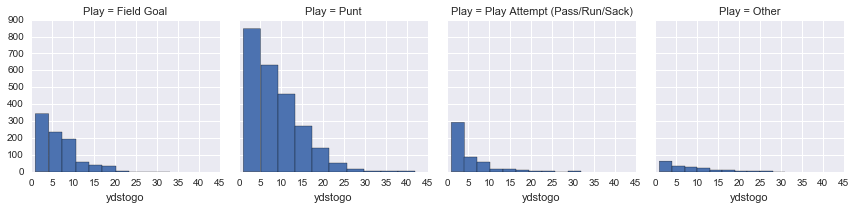

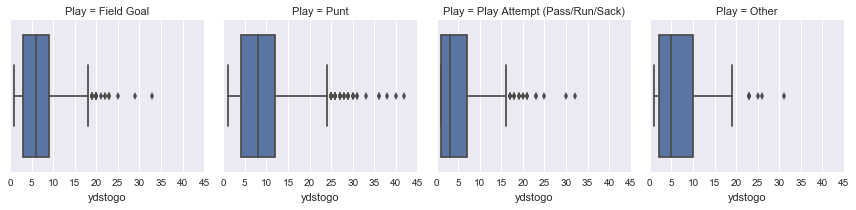

In [70]:
g1 = sns.FacetGrid(fourth_plays, col='Play')
g1.map(plt.hist, 'ydstogo')

g1 = sns.FacetGrid(fourth_plays, col='Play')
g1.map(sns.boxplot, 'ydstogo')
sns.plt.show()

## Wins vs. 4th Down Conversion Percentage

In [71]:
standings15 = pd.read_csv('../data/standings2015.csv')
fourth_plays_vc = dict(fourth_plays['posteam'].value_counts())
attempts_vc = dict(attempts['posteam'].value_counts())
standings15['4thPossesions'] = standings15['Team'].map(fourth_plays_vc)
standings15['4thAttempts'] = standings15['Team'].map(attempts_vc)
standings15['PercentAttempts'] = standings15['4thAttempts']/standings15['4thPossesions']


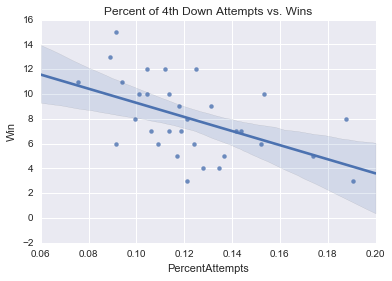

In [72]:
sns.regplot(standings15['PercentAttempts'], standings15['Win'])
plt.title('Percent of 4th Down Attempts vs. Wins')

In [73]:
model = ols('Win~PercentAttempts', standings15).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     10.50
Date:                Mon, 15 Aug 2016   Prob (F-statistic):            0.00291
Time:                        18:02:13   Log-Likelihood:                -75.758
No. Observations:                  32   AIC:                             155.5
Df Residuals:                      30   BIC:                             158.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          14.9753      2.203      6.797      0.000        10.476    19.475
PercentAttempts   -56.8945     17.555     -3.241      0.003       -92.746   -21.043
==============================================================================
Omnibus:                        1.006   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.605   Jarque-Bera (JB):                0.854
Skew:                           0.108   Prob(JB):                        0.652
Kurtosis:                       2.230   Cond. No.                         37.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Summary
While it is generally agreed upon that 4th down possessions are under utilized by teams, this data seems to contradict that fact.  There is a negative correlation between how often a team attempts to convert a 4th down and the number of wins a team has.  We see that that the true coef for PercentAttempts falls in quite a large range (-93, -21) and that with an R^2 value of 0.024, about 1/4 of all wins can be attributed to PercentAttempts.  This means in a 256 game season among all teams, approximately 64 wins were affected by attempts on 4th Down.   

However, I do not believe that this can reliably attest to the discussion of whether or not to go for it on 4th Down.  We see that that no team even attempts 1/4 of their 4th downs.  For now, I posit that there is insufficient data resulting from a reluctance of coaches to make an attempt.  This is also a limited set as it is only data for the 2015 season.  